In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import gaussian_filter1d

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [2]:
file_path = '153 datasets/IFF_ATL+ASDEX_20190701_050133_85886.csv'
data = pd.read_csv(file_path, header=None, skiprows=20, on_bad_lines='skip')
print(data.head())

# clean up, select data which have geodata 
data_cleaned = data[data[9].astype(str).str.len() == 8]

# 定义 haversine 函数，用于计算两点之间的距离（单位：米）
def haversine(lat1, lon1, lat2, lon2):
    # 将经纬度转换为弧度
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # 地球半径（米）
    R = 6371000
    
    # 计算差值
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # 计算haversine公式
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

C:\Users\v2735\AppData\Local\Temp\ipykernel_25148\805054690.py:2: DtypeWarning: Columns (23,26,27,36,39,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, header=None, skiprows=20, on_bad_lines='skip')


   0             1       2       3   4          5      6        7   8   \
0   3  1.561957e+09  638139  2267.0 NaN  ATL+ASDEX  0xE02  SWA4725   1   
1   3  1.561957e+09  638139  2267.0 NaN  ATL+ASDEX  0xE02  SWA4725   1   
2   3  1.561957e+09  638139  2267.0 NaN  ATL+ASDEX  0xE02  SWA4725   1   
3   3  1.561957e+09  638139  2267.0 NaN  ATL+ASDEX  0xE02  SWA4725   1   
4   3  1.561957e+09  638139  2267.0 NaN  ATL+ASDEX  0xE02  SWA4725   1   

         9   ...   35   36     37  38      39  40   41   42   43  44  
0  33.64348  ...  NaN  JAC  375.0 NaN  acdde3 NaN  NaN  NaN  NaN NaN  
1  33.64355  ...  NaN  JAC  375.0 NaN  acdde3 NaN  NaN  NaN  NaN NaN  
2  33.64362  ...  NaN  JAC  375.0 NaN  acdde3 NaN  NaN  NaN  NaN NaN  
3  33.64366  ...  NaN  JAC  375.0 NaN  acdde3 NaN  NaN  NaN  NaN NaN  
4  33.64371  ...  NaN  JAC  375.0 NaN  acdde3 NaN  NaN  NaN  NaN NaN  

[5 rows x 45 columns]


In [3]:
# 创建空列表存储速度
speeds = []

# 遍历每个轨迹
for _, group in data_cleaned.groupby(2):  # 2表示 trajectory ID 列的下标
    group = group.sort_values(by=1)  # 1 表示时间戳列的下标
    
    # 将纬度和经度转换为numpy数组
    latitudes = group[9].values
    longitudes = group[10].values
    timestamps = group[1].values
    # 将 latitudes 和 longitudes 列转换为浮点数类型
    latitudes = latitudes.astype(float)
    longitudes = longitudes.astype(float)

    # 计算速度
    group_speeds = [0]  # 第一个点速度为 0
    for i in range(1, len(group)):
        # 计算时间差（秒）
        time_diff = timestamps[i] - timestamps[i - 1]
        
        # 计算距离（假设以米计算）
        distance = haversine(latitudes[i-1], longitudes[i-1], latitudes[i], longitudes[i])
        
        # 计算速度（m/s），避免除以零
        speed = distance / time_diff if time_diff != 0 else 0
        group_speeds.append(speed)
    
    # 将此组速度添加到总速度列表
    speeds.extend(group_speeds)

# 将速度列添加到数据集中
data_cleaned['speed'] = speeds

C:\Users\v2735\AppData\Local\Temp\ipykernel_25148\1928417054.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['speed'] = speeds


In [4]:
# 这里只选择一条轨迹数据进行示例
trajectory_id = 638142
trajectory_data = data_cleaned[data_cleaned[2] == trajectory_id]

# 选取速度和时间戳
speeds = trajectory_data['speed'].values
timestamps = trajectory_data[1].values

# 对速度数据进行平滑处理（例如高斯滤波）
sigma = 2  # 标准差
speeds_smoothed = gaussian_filter1d(speeds, sigma=sigma)

# 归一化平滑后的速度数据
scaler = MinMaxScaler(feature_range=(0, 1))
speeds_scaled = scaler.fit_transform(speeds_smoothed.reshape(-1, 1))


# 准备训练数据
def create_dataset(dataset, time_step):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

In [5]:
time_step = 2
X,y = create_dataset(speeds_scaled, time_step)

# 调整输入形状为LSTM输入所需的三维
X = X.reshape(X.shape[0], X.shape[1], 1)

# 构建LSTM模型
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [6]:
# 训练模型

# 将数据划分为训练集和测试集
train_size = int(len(speeds_scaled) * 0.8)
train_data = speeds_scaled[:train_size]
test_data = speeds_scaled[train_size:]

# 创建训练集
X_train, y_train = create_dataset(train_data, time_step)

# 创建测试集
X_test, y_test = create_dataset(test_data, time_step)

# 调整输入形状
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model.fit(X, y, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
1466/1466 - 25s - loss: 0.0029 - 25s/epoch - 17ms/step
Epoch 2/10
1466/1466 - 16s - loss: 0.0015 - 16s/epoch - 11ms/step
Epoch 3/10
1466/1466 - 15s - loss: 0.0012 - 15s/epoch - 10ms/step
Epoch 4/10
1466/1466 - 17s - loss: 7.6424e-04 - 17s/epoch - 11ms/step
Epoch 5/10
1466/1466 - 14s - loss: 4.9316e-04 - 14s/epoch - 10ms/step
Epoch 6/10
1466/1466 - 15s - loss: 3.9926e-04 - 15s/epoch - 10ms/step
Epoch 7/10
1466/1466 - 14s - loss: 2.4239e-04 - 14s/epoch - 10ms/step
Epoch 8/10
1466/1466 - 15s - loss: 4.8063e-04 - 15s/epoch - 11ms/step
Epoch 9/10
1466/1466 - 15s - loss: 3.2688e-04 - 15s/epoch - 10ms/step
Epoch 10/10
1466/1466 - 15s - loss: 2.7281e-04 - 15s/epoch - 10ms/step


39/39 [==============================] - 3s 8ms/step


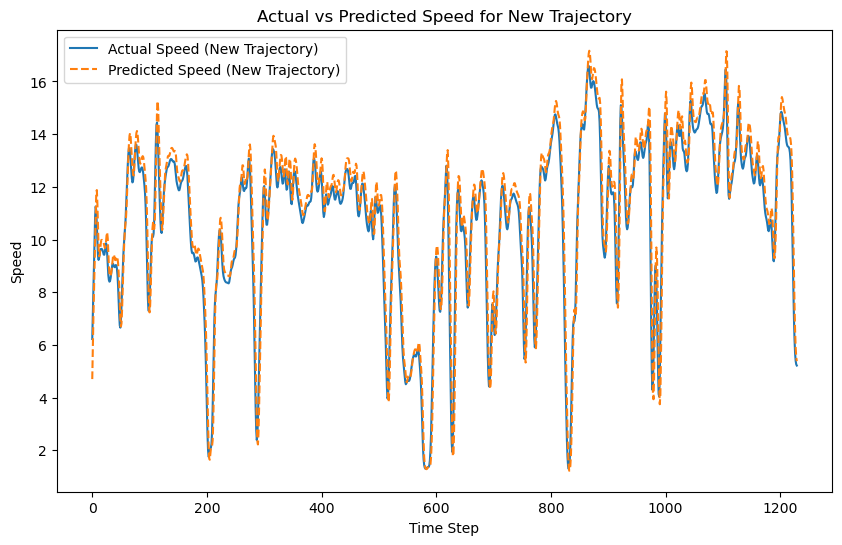

In [7]:
# 使用新的轨迹 ID 进行预测
new_trajectory_id = 638145
new_trajectory_data = data_cleaned[data_cleaned[2] == new_trajectory_id]

# 选取新轨迹的速度数据
new_speeds = new_trajectory_data['speed'].values

# 可选：对新轨迹速度数据进行平滑处理（如高斯滤波）
sigma = 2  # 选择合适的平滑系数
new_speeds_smoothed = gaussian_filter1d(new_speeds, sigma=sigma)

# 使用已拟合的scaler进行归一化处理
new_speeds_scaled = scaler.transform(new_speeds_smoothed.reshape(-1, 1))

# 准备新轨迹数据的输入格式
def create_dataset(dataset, time_step=5):
    X = []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
    return np.array(X)

# 使用相同的时间步长度来创建输入数据
time_step = 2
X_new = create_dataset(new_speeds_scaled, time_step)

# 调整形状以匹配LSTM输入
X_new = X_new.reshape(X_new.shape[0], X_new.shape[1], 1)

# 用训练好的模型进行预测
new_predict = model.predict(X_new)

# 将预测结果反归一化，得到原始速度范围的预测值
new_predict = scaler.inverse_transform(new_predict)

# 可视化实际值和预测值的对比
actual_new_speed = scaler.inverse_transform(new_speeds_scaled[time_step+1:])  # 真实的速度值

plt.figure(figsize=(10, 6))
plt.plot(actual_new_speed, label='Actual Speed (New Trajectory)')
plt.plot(new_predict, label='Predicted Speed (New Trajectory)', linestyle='dashed')
plt.xlabel('Time Step')
plt.ylabel('Speed')
plt.title('Actual vs Predicted Speed for New Trajectory')
plt.legend()
plt.show()

39/39 [==============================] - 3s 13ms/step


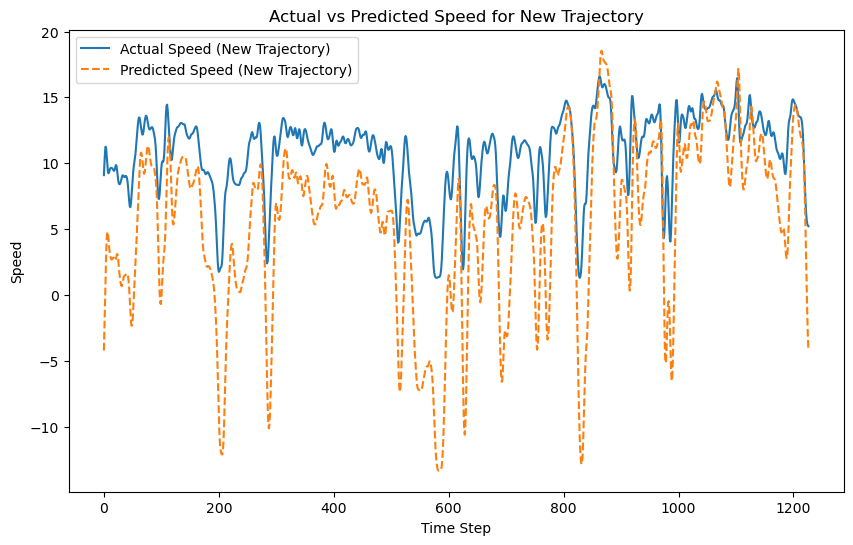

In [8]:
time_step = 5
X_new = create_dataset(new_speeds_scaled, time_step)

# 调整形状以匹配LSTM输入
X_new = X_new.reshape(X_new.shape[0], X_new.shape[1], 1)

# 用训练好的模型进行预测
new_predict = model.predict(X_new)

# 将预测结果反归一化，得到原始速度范围的预测值
new_predict = scaler.inverse_transform(new_predict)

# 可视化实际值和预测值的对比
actual_new_speed = scaler.inverse_transform(new_speeds_scaled[time_step+1:])  # 真实的速度值

plt.figure(figsize=(10, 6))
plt.plot(actual_new_speed, label='Actual Speed (New Trajectory)')
plt.plot(new_predict, label='Predicted Speed (New Trajectory)', linestyle='dashed')
plt.xlabel('Time Step')
plt.ylabel('Speed')
plt.title('Actual vs Predicted Speed for New Trajectory')
plt.legend()
plt.show()